In [35]:
import pandas as pd, seaborn as sns, numpy as np
from pylab import subplots, show, tight_layout, savefig
from ete3 import PhyloTree

Tree pruning

In [24]:
RepeatsGrouped = pd.read_csv('../data/DataFrame/RepeatsGrouped.tsv', sep = '\t')

In [25]:
Repeats = pd.read_csv('../data/DataFrame/Repeats.tsv', sep = '\t')
alias_family = Repeats.set_index('ALIAS')['FAMILY'].to_dict()

In [26]:
tree101 = PhyloTree('../data/trees/ALIASES_NEWICK_101g_nucl_conc_28bfossils.combined.tre') # Zuza

ancs = []
for i in Repeats[Repeats['ALIAS'].isin(tree101.get_leaf_names())].groupby('FAMILY')['ALIAS']:
    if len(i[1]) > 1:
        nodes = []
        for name in i[1].values:
            nodes.append(tree101.get_leaves_by_name(name)[0])
        anc = tree101.get_common_ancestor(nodes)
        anc.name = i[0]
        ancs.append(anc)
            
    else:
        nodes = []
        for name in i[1].values:
            nodes.append(tree101.get_leaves_by_name(name)[0])
    #    for node in nodes:
    #        anc = node.get_ancestors()[0]
    #        anc.name = i[0]
        for node in nodes:
            node.name = i[0]
            ancs.append(node)
            
tree101.prune(ancs, preserve_branch_length=True)

# replacing blank node names
for n, node in enumerate(tree101.traverse()):
    if node.is_leaf() == False:
        node.name = node.name + '_' + str(n)
tree101.write(outfile = '../data/Trees/ALIASES_NEWICK_101g_nucl_conc_28bfossils.combined.families_stem.tre',
              format = 1)

In [27]:
def abline(intercept, slope, ax):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', lw = 5)

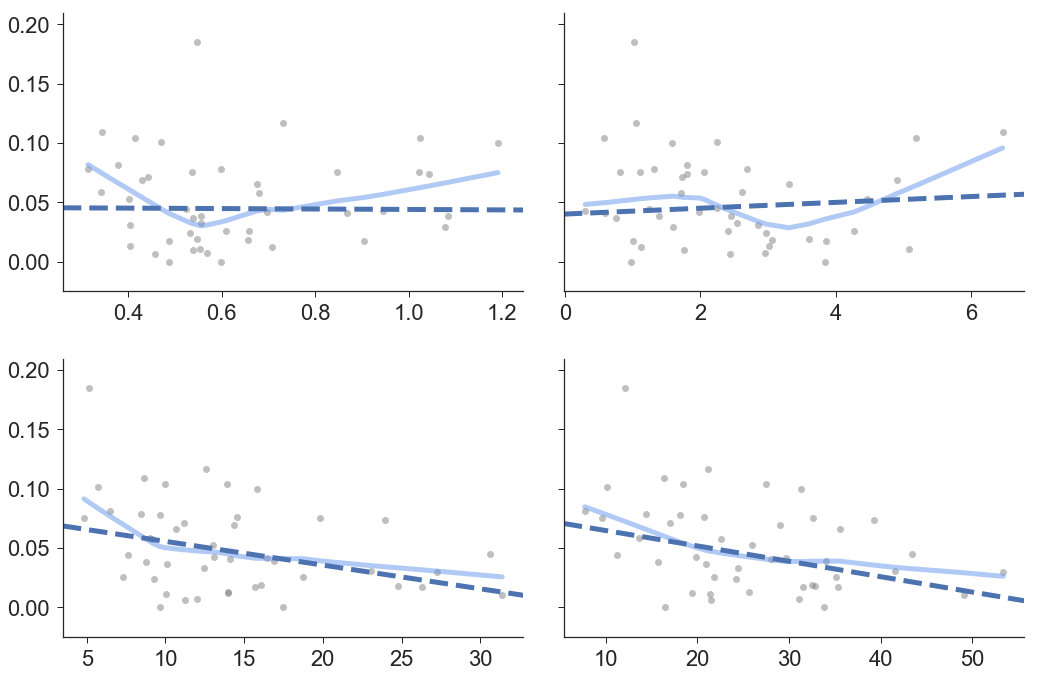

In [42]:
f, axes = subplots(nrows = 2, ncols = 2, figsize = (15, 10), sharey = True, sharex = False)
axes = axes.flatten()

data = RepeatsGrouped.set_index('FAMILY')

c = -1

# OLS results from R
s_i = {'bp' : (0.0458083, -0.0018559), # PGLS
       'strs_perc' : (0.040066894, 0.002459019), # PGLS
       'TEs' : (0.075557832, -0.001998004), # PGLS
       'Total' : (0.07766474,  -0.00129503)} # PGLS

div_rate = 'div_rate_e5_family'

line_kws = {'lw' : 5, 'color' : 'cornflowerblue', 'alpha' : 0.5}
scatter_kws = {'color' : 'gray', 'alpha' : 0.5}
for var in ['bp', 'strs_perc', 'TEs', 'Total']:
    c += 1
    if c == 0:
        data_no_salmonidae = data.drop('Salmonidae')
        ax = axes[c]
        x = np.array(data_no_salmonidae[var]) / 1e9
        y = np.array(data_no_salmonidae[div_rate])
        sns.set(font_scale=2.2, style = 'ticks')
        sns.regplot(ax = ax, x = x, y = y, scatter = True, fit_reg = False, color = 'black', scatter_kws=scatter_kws)
        sns.regplot(ax = ax, x = x, y = y, scatter = False, lowess = True, color = 'gray', line_kws = line_kws)
        abline(s_i[var][0], s_i[var][1], ax)
    else:
        ax = axes[c]
        x = np.array(data[var])
        y = np.array(data[div_rate])
        sns.set(font_scale=2.2, style = 'ticks')
        sns.regplot(ax = ax, x = x, y = y, scatter = True, fit_reg = False, color = 'black', scatter_kws=scatter_kws)
        sns.regplot(ax = ax, x = x, y = y, scatter = False, lowess = True, color = 'gray', line_kws = line_kws)
        abline(s_i[var][0], s_i[var][1], ax)
for ax in f.get_axes():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
tight_layout()

savefig('../figures/divrates_regressions.pdf', type = 'pdf', transparent = True)
savefig('../figures/divrates_regressions.png', type = 'png', transparent = True, dpi = 300)


show()